In [1]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import mean_absolute_error, f1_score, confusion_matrix, accuracy_score
from sklearn.model_selection import KFold, StratifiedKFold, ParameterGrid
from sklearn.linear_model import Lasso
from multiprocess import Pool

In [2]:
player_df = pd.read_csv('../data/nhl-player-data-explored.csv')
player_df.head()

,rank,player,nick,age,position,team,games_played,goals,assists,points,...,num_blocked_shots,num_hits,faceoff_wins,faceoff_losses,faceoff_success_rate,num_HT_wins,num_HT_votes,season,traded_next_season,num_HT_votes_next_season
0,1,Connor McDavid,mcdavco01,20,C,EDM,82,30,70,100,...,29.0,34,348.0,458.0,43.2,1,1604,2017,0.0,270.0
1,2,Sidney Crosby,crosbsi01,29,C,PIT,75,44,45,89,...,27.0,80,842.0,906.0,48.2,0,1104,2017,0.0,1.0
2,3,Patrick Kane,kanepa01,28,RW,CHI,82,34,55,89,...,15.0,28,7.0,44.0,13.7,0,206,2017,0.0,0.0
3,4,Nicklas Backstrom,backsni02,29,C,WSH,82,23,63,86,...,33.0,45,685.0,648.0,51.4,0,60,2017,0.0,0.0
4,5,Nikita Kucherov,kucheni01,23,RW,TBL,74,40,45,85,...,20.0,30,0.0,0.0,NaN,0,119,2017,0.0,166.0


In [3]:
player_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12326 entries, 0 to 12325
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   rank                      12326 non-null  int64  
 1   player                    12326 non-null  object 
 2   nick                      12326 non-null  object 
 3   age                       12326 non-null  int64  
 4   position                  12326 non-null  object 
 5   team                      12326 non-null  object 
 6   games_played              12326 non-null  int64  
 7   goals                     12326 non-null  int64  
 8   assists                   12326 non-null  int64  
 9   points                    12326 non-null  int64  
 10  plus_minus                12326 non-null  int64  
 11  penalty_minutes           12326 non-null  int64  
 12  team_points_ratio         12326 non-null  float64
 13  num_goals_5on5            12326 non-null  int64  
 14  num_go

In [4]:
player_df.describe()

,rank,age,games_played,goals,assists,points,plus_minus,penalty_minutes,team_points_ratio,num_goals_5on5,...,num_blocked_shots,num_hits,faceoff_wins,faceoff_losses,faceoff_success_rate,num_HT_wins,num_HT_votes,season,traded_next_season,num_HT_votes_next_season
count,12326.000000,12326.000000,12326.000000,12326.000000,12326.000000,12326.000000,12326.000000,12326.000000,12326.000000,12326.000000,...,12326.000000,12326.000000,12326.000000,12326.000000,6152.000000,12326.000000,12326.000000,12326.000000,7795.000000,8574.000000
mean,629.903781,26.642869,48.910352,7.485478,12.789794,20.275272,-0.351858,31.976148,2.480472,5.388042,...,29.446049,47.277949,62.312591,62.311618,42.256518,0.001136,3.317621,2011.437612,0.248621,4.293445
std,553.907982,4.576861,28.662179,8.847140,13.129551,20.778556,9.415412,32.314859,2.813359,6.127377,...,38.987808,54.328338,160.318023,152.305063,21.427258,0.033684,53.899779,4.170480,0.432241,61.592151
min,1.000000,18.000000,1.000000,0.000000,0.000000,0.000000,-46.000000,0.000000,-1.900000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2004.000000,0.000000,0.000000
25%,257.000000,23.000000,21.000000,1.000000,2.000000,3.000000,-5.000000,8.000000,0.200000,1.000000,...,0.000000,1.000000,0.000000,0.000000,33.300000,0.000000,0.000000,2008.000000,0.000000,0.000000
50%,514.000000,26.000000,57.000000,4.000000,9.000000,14.000000,-1.000000,24.000000,1.600000,3.000000,...,15.000000,30.000000,0.000000,0.000000,45.900000,0.000000,0.000000,2012.000000,0.000000,0.000000
75%,771.000000,30.000000,76.000000,11.000000,20.000000,32.000000,4.000000,45.000000,4.100000,8.000000,...,41.000000,75.000000,14.000000,19.000000,51.700000,0.000000,0.000000,2015.000000,0.000000,0.000000
max,2644.000000,48.000000,84.000000,65.000000,96.000000,125.000000,50.000000,324.000000,17.200000,48.000000,...,283.000000,382.000000,1273.000000,941.000000,100.000000,1.000000,1604.000000,2018.000000,1.000000,1604.000000


# 1. Perform transformations we decided we need to do during data analysis

One-hot encode the position of a player that he played in for the given record.

In [5]:
player_df.loc[player_df.position == 'W', 'position'] = 'LW/RW'

player_df['position_C'] = player_df.position.str.contains('C')
player_df['position_LW'] = player_df.position.str.contains('LW')
player_df['position_RW'] = player_df.position.str.contains('RW')
player_df['position_F'] = player_df['position_C'] | player_df['position_LW'] | player_df['position_RW']
player_df['position_D'] = player_df.position.str.contains('D')

# 2. Num goals next season

First we need to create this column. Let's do it then.

In [6]:
player_df['goals_next_season'] = np.nan
for row_idx in tqdm(range(len(player_df)), 'Creating the goals next season feature'):
    player = player_df.iloc[row_idx]
    player_records = player_df[player_df.nick == player.nick]
    next_season = player_records[player_records.season == player.season + 1]
    if len(next_season) == 1:
        goals = next_season.iloc[0].goals
        player_df.loc[row_idx, 'goals_next_season'] = goals

Creating the goals next season feature:   0%|          | 0/12326 [00:00<?, ?it/s]

Now let's fill in NaN data and drop columns that:
- the model shold not have information about
- we don't want the model to use

In [7]:
TO_DROP = ['player', 'nick', 'position', 'team', 'num_HT_wins', 'num_HT_votes_next_season', 'traded_next_season']
data = player_df.copy().drop(columns=TO_DROP)
data = data[~np.isnan(data.goals_next_season)]
data.loc[np.isnan(data.shoot_success_rate), 'shoot_success_rate'] = 0
data.loc[np.isnan(data.faceoff_success_rate), 'faceoff_success_rate'] = 0

X = data.copy().drop(columns=['goals_next_season'])
y = data[['goals_next_season']]

Perform hyperparameter search using 5-Fold CV.

In [8]:
results = {}
folder = KFold(n_splits=5, shuffle=True, random_state=42)

best_k = None
best_v = None

space = np.linspace(0.05, 0.3, 25) + 0.01
for alpha in tqdm(space, desc='Checking all Lasso models'):
    mae_train = []
    mae_test = []
    for train, test in folder.split(X, y):
        model = Lasso(alpha=alpha, random_state=42, positive=True, fit_intercept=True, max_iter=10_000, selection='random')
        model.fit(X.iloc[train], y.iloc[train])

        y_hat_train = model.predict(X.iloc[train])
        y_hat_test = model.predict(X.iloc[test])

        mae_train.append(mean_absolute_error(y.iloc[train], y_hat_train))
        mae_test.append(mean_absolute_error(y.iloc[test], y_hat_test))

    if best_k is None or best_v > np.mean(mae_test):
        best_k = alpha
        best_v = np.mean(mae_test)
    results[alpha] = {
        'model': model,
        'mae_train': np.mean(mae_train),
        'mae_test': np.mean(mae_test),
    }

Checking all Lasso models:   0%|          | 0/25 [00:00<?, ?it/s]

In [9]:
best_k, best_v

(0.13291666666666666, 4.167064047451775)

Plot what MAE looks like as with respect to the $\alpha$ parameter.

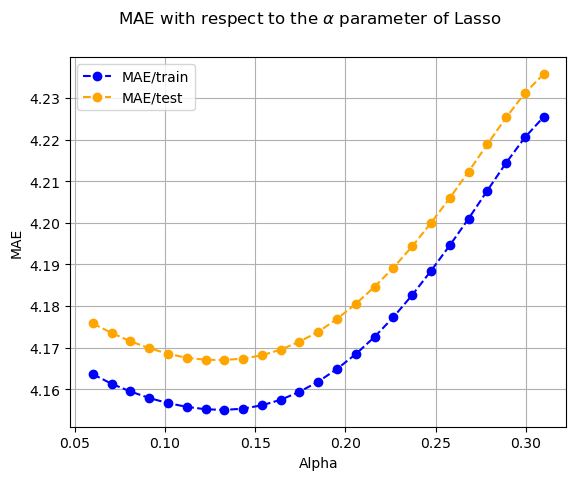

In [10]:
plt.plot(space, [results[k]['mae_train'] for k in space], '--o', label='MAE/train', color='blue')
plt.plot(space, [results[k]['mae_test'] for k in space], '--o', label='MAE/test', color='orange')
plt.grid()
plt.xlabel('Alpha')
plt.ylabel('MAE')
plt.suptitle(r'MAE with respect to the $\alpha$ parameter of Lasso')
plt.legend();

Obtain the best model again, now on all of the data.

In [11]:
model = Lasso(alpha=best_k, fit_intercept=False, positive=True, max_iter=10_000)
model.fit(X, y)
mae_regular = mean_absolute_error(y, model.predict(X))

Now let's see the MAE if we continuously try to set more and more coefficients to 0.

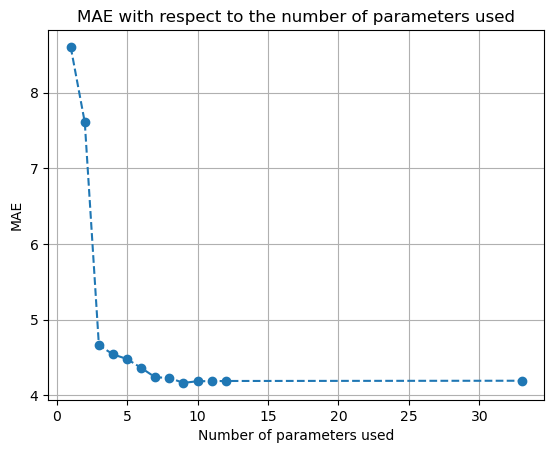

In [12]:
steps = sorted(np.unique(np.abs(model.coef_)), reverse=False)

fig, ax = plt.subplots()
x_data = steps
y_data = []
for step in steps:
    coef_reduced = model.coef_.copy()
    coef_reduced[np.abs(coef_reduced) <= step] = 0
    y_hat = (X @ coef_reduced.T) + model.intercept_
    y_hat[y_hat < 0] = 0
    mae_reduced = mean_absolute_error(y, y_hat)
    y_data.append(mae_reduced)
x_range = np.arange(len(y_data)) + 1
x_range[-1] = model.coef_.shape[0] + 1
ax.plot(x_range, y_data[::-1], '--o')
ax.set_xlabel('Number of parameters used')
ax.set_ylabel('MAE')
ax.set_title('MAE with respect to the number of parameters used')
ax.grid()

We see that at 10 parameters used, we get a very good MAE already. Let's therefore have a look at what parameters are they.

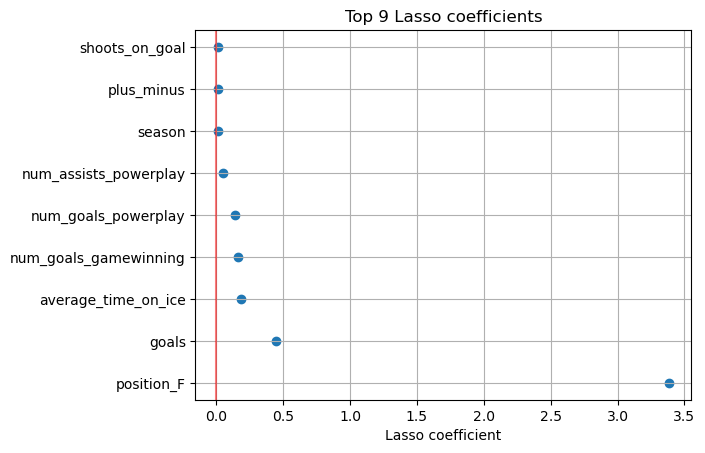

In [13]:
vals = sorted(zip(results[best_k]['model'].coef_, X.columns), key=lambda x: -np.abs(x[0]))[:9]
fig, ax = plt.subplots()
ax.scatter([x[0] for x in vals], [x[1] for x in vals])
ax.axvline(0, 0, 10, color='red', alpha=0.5)
ax.set_xlabel('Lasso coefficient')
ax.set_title('Top 9 Lasso coefficients')
ax.grid()

Text(0.5, 1.0, 'Mean goals per player per game with respect to the season')

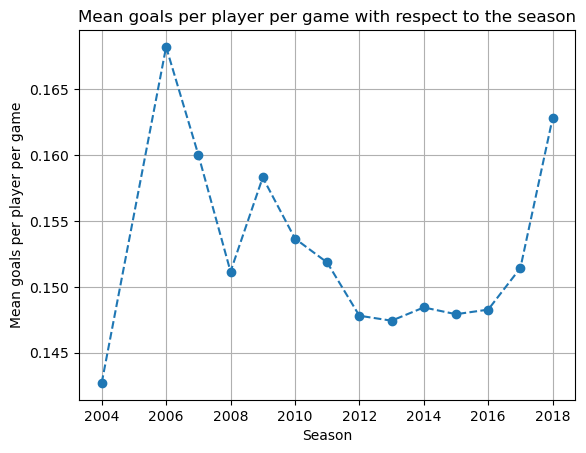

In [14]:
data_1 = player_df.groupby(['season', 'nick']).agg({'goals': 'sum', 'games_played': 'sum'}).groupby('season').mean()

fig, ax = plt.subplots()
ax.plot(data_1.goals / data_1.games_played, '--o')
ax.grid()
ax.set_xlabel('Season')
ax.set_ylabel('Mean goals per player per game')
ax.set_title('Mean goals per player per game with respect to the season')

# 3. Probability of a player being traded in the next season

Let's define the data we will use for this again.

In [15]:
TO_DROP = ['player', 'nick', 'position', 'team', 'num_HT_wins', 'num_HT_votes_next_season', 'goals_next_season', 'rank']
data = player_df.copy().drop(columns=TO_DROP)
data = data[~np.isnan(data.traded_next_season)]
data.loc[np.isnan(data.shoot_success_rate), 'shoot_success_rate'] = 0
data.loc[np.isnan(data.faceoff_success_rate), 'faceoff_success_rate'] = 0

np.any(np.isnan(data))

False

Perfect, we have no NaNs now, so we can start modeling.

In [16]:
X = data.drop(columns=['traded_next_season'])
y = data[['traded_next_season']]

In [17]:
param_grid = ParameterGrid({
    'max_depth': np.arange(1, 6),
    'criterion': ['gini', 'entropy'],
    'random_state': [42],
    'class_weight': ['balanced']
})

folder = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
pool = Pool(processes=12)

def get_res(params):
    model = DecisionTreeClassifier(**params)
    f1_train = []
    f1_test = []
    cm_test = []
    for train, test in folder.split(X, y):
        model = DecisionTreeClassifier(**params)
        X_train, X_test, y_train, y_test = X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test]
        model.fit(X_train, y_train.traded_next_season)
        f1_train.append(f1_score(y_train, model.predict(X_train)))
        f1_test.append(f1_score(y_test, model.predict(X_test)))
        cm_test.append(confusion_matrix(y_test, model.predict(X_test)))
    return {
        'model': model,
        'params': params,
        'f1/train': np.mean(f1_train),
        'f1/test': np.mean(f1_test),
        'cm/test': np.mean(cm_test)
    }

results = list(tqdm(pool.imap(get_res, param_grid, chunksize=4), desc='Getting all models', total=len(param_grid)))

Getting all models:   0%|          | 0/10 [00:00<?, ?it/s]

In [18]:
results[0]['params']

{'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 1,
 'random_state': 42}

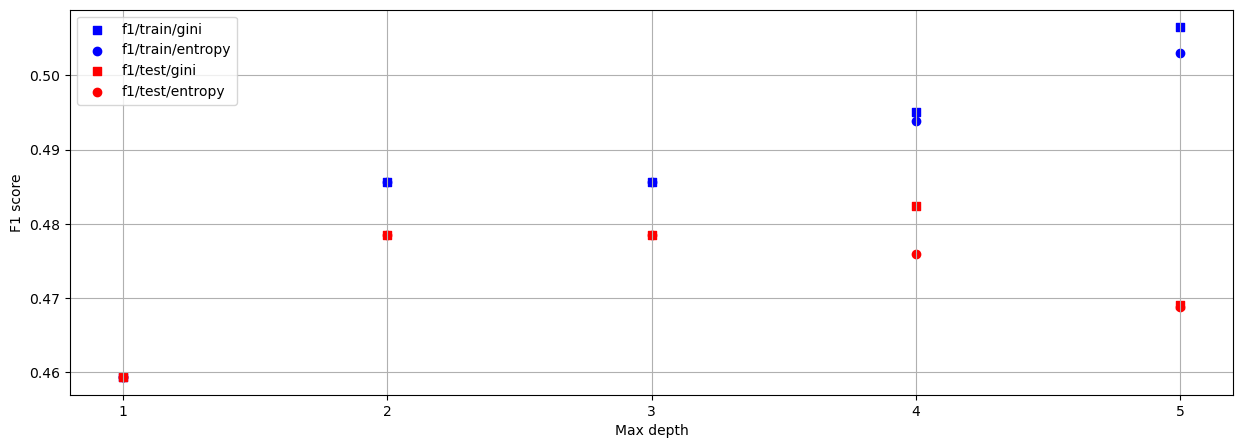

In [19]:
plt.figure(figsize=(15, 5))

for dataset in ['train', 'test']:
    for crit in ['gini', 'entropy']:
        plt.scatter([
            x['params']['max_depth'] for x in results
            if x['params']['criterion'] == crit
        ], [
            x[f'f1/{dataset}'] for x in results 
            if x['params']['criterion'] == crit
        ], label=f'f1/{dataset}/{crit}',
        color='blue' if dataset == 'train' else 'red',
        marker='s' if crit == 'gini' else 'o')
plt.ylabel('F1 score')
plt.xlabel('Max depth')
plt.grid()
plt.xticks(np.arange(1, 6))
plt.legend()

In [20]:
f = (X.age > 24.5) & (X.average_time_on_ice <= 17.94)
y[f]

,traded_next_season
18,0.0
33,0.0
34,0.0
36,0.0
47,0.0
...,...
12300,0.0
12304,1.0
12307,1.0
12309,1.0


In [21]:
y[f].describe()

,traded_next_season
count,3411.000000
mean,0.379654
std,0.485372
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


array([[0.6387229 , 0.3612771 ],
       [0.33178535, 0.66821465]])

TypeError: missing a required argument: 'y_pred'

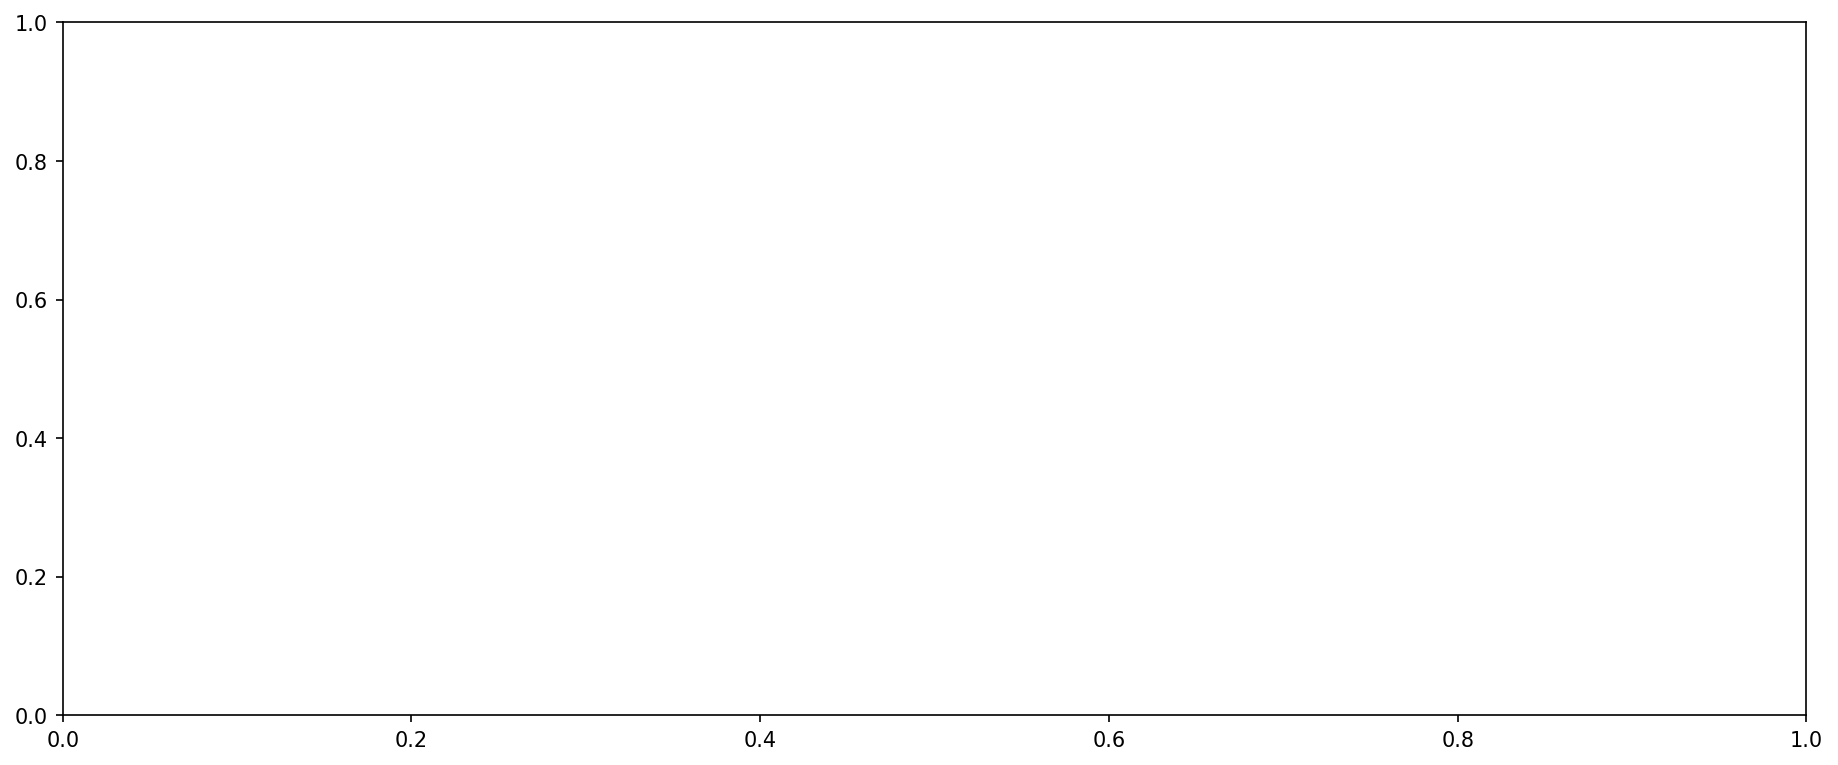

In [22]:
fig, ax = plt.subplots(figsize=(15, 6), dpi=150)

model = results[7]['model']
model.fit(X.values, y.traded_next_season)
# model.tree_.value[..., 0] *= (5857 / 3897.5)
# model.tree_.value[..., 1] *= (1938 / 3897.5)
# model.class_weight = None

display(confusion_matrix(y, model.predict(X.values), normalize='true'))
display(accuracy_score(y, model.predict(X.values)))

res = plot_tree(model, precision=2, ax=ax, feature_names=X.columns, class_names={0: 'Not traded', 1: 'Traded'}, filled=True, proportion=True)